# Setup and cleaning the data

In [ ]:
!pip install pycaret

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_recall_curve
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from pycaret.classification import *

import torch
from torch.utils.data import Dataset,DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DS203 Project/heart.csv')

In [ ]:
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
# Imputing the zero values of cholestrol
df['Cholesterol'].replace(0,df['Cholesterol'].mean(),inplace=True)

In [ ]:
df[df['RestingBP']==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,198.799564,0,Normal,155,N,1.5,Flat,1


In [ ]:
for col in df.columns:
    print(col)
    print(df[col].unique())

Age
[40 49 37 48 54 39 45 58 42 38 43 60 36 44 53 52 51 56 41 32 65 35 59 50
 47 31 46 57 55 63 66 34 33 61 29 62 28 30 74 68 72 64 69 67 73 70 77 75
 76 71]
Sex
['M' 'F']
ChestPainType
['ATA' 'NAP' 'ASY' 'TA']
RestingBP
[140 160 130 138 150 120 110 136 115 100 124 113 125 145 112 132 118 170
 142 190 135 180 108 155 128 106  92 200 122  98 105 133  95  80 137 185
 165 126 152 116   0 144 154 134 104 139 131 141 178 146 158 123 102  96
 143 172 156 114 127 101 174  94 148 117 192 129 164]
Cholesterol
[289.         180.         283.         214.         195.
 339.         237.         208.         207.         284.
 211.         164.         204.         234.         273.
 196.         201.         248.         267.         223.
 184.         288.         215.         209.         260.
 468.         188.         518.         167.         224.
 172.         186.         254.         306.         250.
 177.         227.         230.         294.         264.
 259.         175.         318

In [ ]:
def encode_and_bind(origdf, feature):
    dummies = pd.get_dummies(origdf[[feature]])
    newdf = pd.concat([origdf, dummies], axis=1)
    newdf = newdf.drop([feature], axis=1)
    return(newdf) 

features_to_encode = ['ChestPainType','ST_Slope','RestingECG']
newdf = df.copy()
for feature in features_to_encode:
    newdf = encode_and_bind(newdf, feature)

In [ ]:
df = newdf 
df.head(5)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,M,140,289.0,0,172,N,0.0,0,0,1,0,0,0,0,1,0,1,0
1,49,F,160,180.0,0,156,N,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,M,130,283.0,0,98,N,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,F,138,214.0,0,108,Y,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,M,150,195.0,0,122,N,0.0,0,0,0,1,0,0,0,1,0,1,0


In [ ]:
df['Sex'].replace({'M':0,'F':1},inplace=True)
df.ExerciseAngina.replace({'N':0,'Y':1},inplace=True)

In [ ]:
# Removing the dead dude,
df.drop(index=449,inplace=True)

In [ ]:
for cols in ['RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']:
    mu = df[cols].mean()
    std = df[cols].std()
    df[cols] = (df[cols]-mu)/std

In [ ]:
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,0,0.414401,0.940521,-0.551432,1.382585,0,-0.831049,0,0,1,0,0,0,0,1,0,1,0
1,49,1,1.525527,-0.996976,-0.551432,0.754324,0,0.106194,1,0,0,1,0,0,1,0,0,1,0
2,37,0,-0.141163,0.833869,-0.551432,-1.523121,0,-0.831049,0,0,1,0,0,0,0,1,0,0,1
3,48,1,0.303288,-0.392619,-0.551432,-1.130458,1,0.574815,1,1,0,0,0,0,1,0,0,1,0
4,54,0,0.969964,-0.730348,-0.551432,-0.580730,0,-0.831049,0,0,0,1,0,0,0,1,0,1,0


In [ ]:
train,val_test = train_test_split(df,test_size=0.3)
val,test = train_test_split(val_test,test_size=0.5)

In [ ]:
X_train,y_train = train.drop(labels=['HeartDisease'],axis=1).values,train['HeartDisease'].values
X_val,y_val = val.drop(labels=['HeartDisease'],axis=1).values,val['HeartDisease'].values
X_test,y_test = test.drop(labels=['HeartDisease'],axis=1).values,test['HeartDisease'].values

In [ ]:
best_params = {}
best_models = {}
best_model_accuracy_test = {}
best_model_accuracy_val = {}
f1_scores = {}

# SVM

In [ ]:
clfsvm = GridSearchCV(svm.SVC(),{
    'C':[0.001,0.1,1,10,100,2000],
    'kernel' : ['rbf']
},n_jobs = 6,verbose=2)
clfsvm.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    4.4s finished


GridSearchCV(estimator=SVC(), n_jobs=6,
             param_grid={'C': [0.001, 0.1, 1, 10, 100, 2000],
                         'kernel': ['rbf']},
             verbose=2)

In [ ]:
pd.DataFrame(clfsvm.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.073373,0.019293,0.010709,0.005114,0.001,rbf,"{'C': 0.001, 'kernel': 'rbf'}",0.550388,0.554688,0.554688,0.554688,0.554688,0.553828,0.001720,6
1,0.052428,0.018755,0.016862,0.008803,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.604651,0.664062,0.609375,0.632812,0.539062,0.609993,0.041241,5
2,0.056710,0.005177,0.013952,0.004551,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.713178,0.718750,0.726562,0.695312,0.578125,0.686386,0.055099,4
3,0.050930,0.005095,0.009347,0.004443,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.844961,0.828125,0.843750,0.843750,0.843750,0.840867,0.006388,3
4,0.039903,0.007614,0.008757,0.003755,100,rbf,"{'C': 100, 'kernel': 'rbf'}",0.852713,0.859375,0.859375,0.843750,0.867188,0.856480,0.007844,2
5,0.096569,0.012903,0.008881,0.004157,2000,rbf,"{'C': 2000, 'kernel': 'rbf'}",0.844961,0.851562,0.898438,0.828125,0.859375,0.856492,0.023365,1


In [ ]:
params = clfsvm.best_params_
params

{'C': 2000, 'kernel': 'rbf'}

In [ ]:
best_params['SVM'] = clfsvm.best_params_
model = svm.SVC(params['C'], params['kernel']).fit(X_train, y_train)
best_models['SVM'] = model
val_preds = model.score(X_val, y_val)
best_model_accuracy_val['SVM'] = val_preds
preds = model.predict(X_test)
best_model_accuracy_test['SVM'] = accuracy_score(y_test, preds)
f1_scores['SVM'] = f1_score(y_test, preds)

# MLPClassifier

In [ ]:
clfnn = GridSearchCV(MLPClassifier(),{
    'hidden_layer_sizes' : [(9,5,2),(10,8,4,2),(16,10,4),(12,6)],
    'learning_rate_init':[ 0.001,0.01,0.1,0.5],
    'activation':['relu','tanh', 'sigmoid'],
    'alpha':[0.01,0.1,0.5,1.0],
    'learning_rate':['constant','adaptive'],
    'solver':['adam','sgd']
},n_jobs = 6,verbose=2)
clfnn.fit(X_train,y_train)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   25.7s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:   59.5s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 1001 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 1446 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 1973 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 2585 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 3840 out of 3840 | elapsed:  8.1min finished


GridSearchCV(estimator=MLPClassifier(), n_jobs=6,
             param_grid={'activation': ['relu', 'tanh', 'sigmoid'],
                         'alpha': [0.01, 0.1, 0.5, 1.0],
                         'hidden_layer_sizes': [(9, 5, 2), (10, 8, 4, 2),
                                                (16, 10, 4), (12, 6)],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.001, 0.01, 0.1, 0.5],
                         'solver': ['adam', 'sgd']},
             verbose=2)

In [ ]:
a = pd.DataFrame(clfnn.cv_results_)
a[a['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
458,1.185115,0.321292,0.000873,0.000018,tanh,1,"(9, 5, 2)",adaptive,0.01,adam,"{'activation': 'tanh', 'alpha': 1.0, 'hidden_l...",0.852713,0.851562,0.875,0.890625,0.890625,0.872105,0.017277,1


In [ ]:
params = clfnn.best_params_
params

{'activation': 'tanh',
 'alpha': 1.0,
 'hidden_layer_sizes': (9, 5, 2),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.01,
 'solver': 'adam'}

In [ ]:
best_params['NN'] = clfnn.best_params_
model = MLPClassifier(activation = params['activation'], hidden_layer_sizes = params['hidden_layer_sizes'], learning_rate = params['learning_rate'], learning_rate_init = params['learning_rate_init'], solver= params['solver']).fit(X_train, y_train)
best_models['NN'] = model
val_preds = model.score(X_val, y_val)
best_model_accuracy_val['NN'] = val_preds
preds = model.predict(X_test)
best_model_accuracy_test['NN'] = accuracy_score(y_test, preds)
f1_scores['NN'] = f1_score(y_test, preds)

# Decision Tree

In [ ]:
clftree = GridSearchCV(DecisionTreeClassifier(),{
    'criterion':['gini','entropy'],
    'max_features':['auto','sqrt','log2'],
    'ccp_alpha':[0.0,0.1,0.2,0.4,0.8]},
    n_jobs = 6,
    verbose=2,
)
clftree.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed:    0.6s finished


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=6,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.4, 0.8],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=2)

In [ ]:
b = pd.DataFrame(clftree.cv_results_)
b[b['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.001704,0.000118,0.000655,0.000119,0,gini,log2,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_f...",0.767442,0.765625,0.867188,0.820312,0.804688,0.805051,0.037584,1


In [ ]:
params = clftree.best_params_
params

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_features': 'log2'}

In [ ]:
best_params['DTC'] = clftree.best_params_
model = DecisionTreeClassifier(ccp_alpha = params['ccp_alpha'], criterion=params['criterion'], max_features = params['max_features']).fit(X_train, y_train)
best_models['DTC'] = model
val_preds = model.score(X_val, y_val)
best_model_accuracy_val['DTC'] = val_preds
preds = model.predict(X_test)
best_model_accuracy_test['DTC'] = accuracy_score(y_test, preds)
f1_scores['DTC'] = f1_score(y_test, preds)

One hot encoder for inputs having more than 2 types<br>
Replace 0 values in cholestrol with mean value


#  Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clfrf = GridSearchCV(RandomForestClassifier(),{
    'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto','sqrt','log2'],
    'ccp_alpha':[0.0,0.1,0.2,0.4,0.8]},
    n_jobs = 6,verbose=2
)
clfrf.fit(X_train,y_train)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    5.2s
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed:   25.6s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.4, 0.8],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=2)

In [ ]:
params = clfrf.best_params_
params

{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_features': 'log2'}

In [ ]:
best_params['RF'] = clfrf.best_params_
model = RandomForestClassifier(criterion= params['criterion'], max_features = params['max_features'], ccp_alpha = params['ccp_alpha']).fit(X_train, y_train)
best_models['RF'] = model
val_preds = model.score(X_val, y_val)
best_model_accuracy_val['RF'] = val_preds
preds = model.predict(X_test)
best_model_accuracy_test['RF'] = accuracy_score(y_test, preds)
f1_scores['RF'] = f1_score(y_test, preds)

In [ ]:
print('Best Parameters: \n')
for i in best_params.keys():
    print(f'{i}: ',best_params[i])
    print()
print('*' * 100)

print('Best Models:\n')
for i in best_models.keys():
    print(f'{i}: ',best_models[i])
    print()
    
print('*' * 100)
print('Results obtained by Best models on validation set: \n')
for i in best_models.keys():
    print(f'{i}: ',best_model_accuracy_val[i])
    print()

print('*' * 100)
print('Results obtained by Best models on test set: \n')
for i in best_models.keys():
    print(f'{i}: ',best_model_accuracy_test[i])
    print()

print('*' * 100)
print('F1 Scores: \n')
for i in best_params.keys():
    print(f'{i}: ',f1_scores[i])
    print()


Best Parameters: 

SVM:  {'C': 2000, 'kernel': 'rbf'}

NN:  {'activation': 'tanh', 'alpha': 1.0, 'hidden_layer_sizes': (9, 5, 2), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'adam'}

DTC:  {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_features': 'log2'}

RF:  {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_features': 'log2'}

****************************************************************************************************
Best Models:

SVM:  SVC(C=2000)

NN:  MLPClassifier(activation='tanh', hidden_layer_sizes=(9, 5, 2),
              learning_rate='adaptive', learning_rate_init=0.01)

DTC:  DecisionTreeClassifier(max_features='log2')

RF:  RandomForestClassifier(criterion='entropy', max_features='log2')

****************************************************************************************************
Results obtained by Best models on validation set: 

SVM:  0.8623188405797102

NN:  0.8115942028985508

DTC:  0.8188405797101449

RF:  0.8695652173913043

****

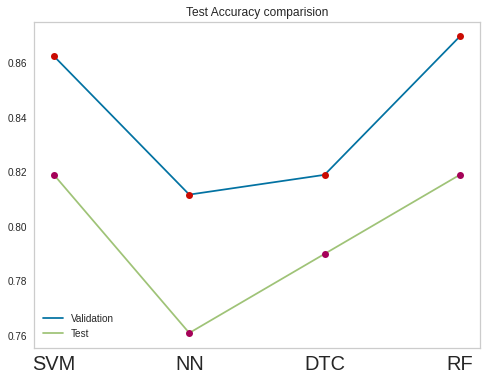

In [ ]:
val_accu = list(best_model_accuracy_val.values())
test_accu = list(best_model_accuracy_test.values())
plt.figure(figsize = (8,6))
plt.grid(False)
plt.plot(val_accu)
plt.plot(test_accu)
plt.plot([0,1.,2.,3.],val_accu,'o')
plt.plot([0,1.,2.,3.],test_accu,'o')
plt.legend(['Validation', 'Test'], fontsize = 10)
ticks = list(best_models.keys())
plt.xticks(ticks = [0,1.,2.,3.], labels = ticks, fontsize = 20)
plt.title('Test Accuracy comparision');

# Using Pytorch for Classification

In [ ]:
class Data(Dataset):
    def __init__(self,data):
        self.labels = np.array(data['HeartDisease'].values)
        self.data = np.array(data.drop(columns='HeartDisease'))

    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self,id):
        return self.data[id],self.labels[id]

    

In [ ]:
dtrain = Data(train)
dval = Data(val)
dtest = Data(test)

In [ ]:
dtrain.data.shape, dval.data.shape, dtest.data.shape

((641, 18), (138, 18), (138, 18))

In [ ]:
batch_size = 32
loaded_train = DataLoader(dtrain,batch_size=batch_size,shuffle=True)
loaded_val = DataLoader(dval,batch_size=batch_size,shuffle=True)
loaded_test = DataLoader(dtest,batch_size=batch_size,shuffle=True)



In [ ]:
class heartNN(torch.nn.Module):
    # 3 hidden layers only!
    def __init__(self,hidden_layer_sizes):
        super().__init__()
        self.layer1 = torch.nn.Linear(18,hidden_layer_sizes[0])
        self.layer2 = torch.nn.Linear(hidden_layer_sizes[0],hidden_layer_sizes[1])
        self.layer3 = torch.nn.Linear(hidden_layer_sizes[1],hidden_layer_sizes[2])
        # self.layer4 = torch.nn.Linear(hidden_layer_sizes[2], hidden_layer_sizes[3])

        self.acti1 = torch.nn.PReLU()
        self.acti2 = torch.nn.Sigmoid()
        self.acti3 = torch.nn.LogSoftmax(dim = -1)
        self.acti4 = torch.nn.ReLU()

    def forward(self,x):
        x = self.layer1(x)
        x = self.acti1(x)
        x = self.layer2(x)
        x = self.acti2(x)
        x = self.layer3(x)
        x = self.acti3(x)
        return x






In [ ]:
def train_model(model,train_data,val_data,loss_fn,epochs=50):
    train_loss = []
    val_loss = []
    train_accu = []
    val_accu = []
    
    for epoch in range(epochs):
        i = 0
        j = 0
        running_train_loss = 0
        running_val_loss = 0
        running_train_accu = 0
        running_val_accu = 0 
        model.train()
        for X, Y in train_data:
            output = model(X.float())
            prediction = torch.argmax(output, dim = -1)
            loss = loss_fn(output, Y.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    


            running_train_loss += loss.item()
            accu = torch.sum(prediction == Y).item()
            running_train_accu += accu
            i+=1
            j+=Y.shape[0]
            
        
        train_loss.append(running_train_loss/i)
        train_accu.append(running_train_accu/j)
        i,j = 0,0

        model.eval()
        for X, Y in val_data:
            with torch.no_grad():
                output = model(X.float())
                Y = Y.long()

            prediction = torch.argmax(output, dim = -1)
            Y = Y.long()
            loss = loss_fn(output, Y)
            running_val_loss += loss.item()
            accu = torch.sum(prediction == Y).item()
            running_val_accu += accu
            i+=1
            j+=Y.shape[0]

        val_loss.append(running_val_loss/i)
        val_accu.append(running_val_accu/j)
        
        if (epoch+1)%20 == 0:
            print(f"""Epoch = {epoch+1}: 
                    training_loss: {train_loss[epoch]:2f}
                    training_accuracy: {train_accu[epoch]:2f}
                    val_loss: {val_loss[epoch]:2f}
                    val_accuracy: {val_accu[epoch]:2f}
                    """)
    return np.array(train_loss), np.array(train_accu), np.array(val_loss), np.array(val_accu), epochs

In [ ]:
hidden_layer_sizes = (12,6,2)
HeartModel = heartNN(hidden_layer_sizes)

loss_fn = torch.nn.NLLLoss()
# loss_fn = torch.nn.CrossEntropyLoss()
# loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(HeartModel.parameters(),lr=0.0001)

train_loss,train_accu,val_loss,val_accu, epochs = train_model(HeartModel,loaded_train,loaded_val,loss_fn=loss_fn,epochs=150)

Epoch = 20: 
                    training_loss: 0.695041
                    training_accuracy: 0.553822
                    val_loss: 0.658499
                    val_accuracy: 0.586957
                    
Epoch = 40: 
                    training_loss: 0.655376
                    training_accuracy: 0.553822
                    val_loss: 0.650562
                    val_accuracy: 0.586957
                    
Epoch = 60: 
                    training_loss: 0.645039
                    training_accuracy: 0.553822
                    val_loss: 0.630199
                    val_accuracy: 0.586957
                    
Epoch = 80: 
                    training_loss: 0.601987
                    training_accuracy: 0.728549
                    val_loss: 0.603385
                    val_accuracy: 0.753623
                    
Epoch = 100: 
                    training_loss: 0.569061
                    training_accuracy: 0.837754
                    val_loss: 0.573320
                    val

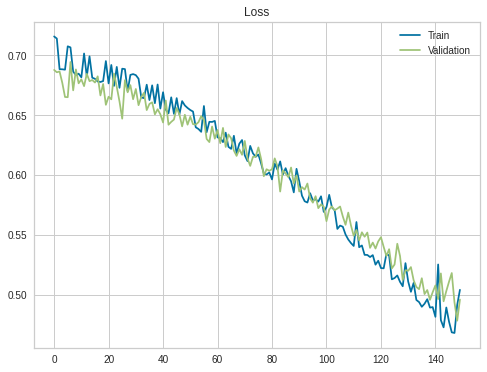

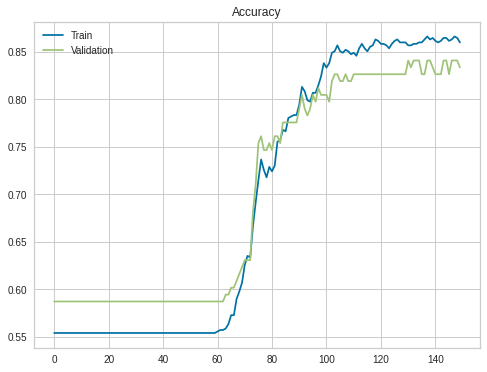

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(epochs),train_loss)
plt.plot(np.arange(epochs),val_loss)
plt.title('Loss')
plt.legend(['Train', 'Validation'])
plt.figure(figsize = (8,6))
plt.plot(np.arange(epochs),train_accu)
plt.plot(np.arange(epochs),val_accu)
plt.title('Accuracy')
plt.legend(['Train', 'Validation'])

In [ ]:
y_true = []
preds = []
for X, Y in loaded_test:
    HeartModel.eval()
    output = HeartModel(X.float())
    prediction = torch.argmax(output, dim = -1)
    for i,j in zip(list(Y.numpy()), list(prediction.numpy())):
        y_true.append(i)
        preds.append(j)
    
print('F1 score obtained from Nueral Network = {}'.format(f1_score(y_true, preds)))
print('Accuracy obtained from Nueral Network = {}'.format(accuracy_score(y_true, preds)))

F1 score obtained from Nueral Network = 0.8111888111888113
Accuracy obtained from Nueral Network = 0.8043478260869565


# PyCaret 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DS203 Project/heart.csv')

In [ ]:
df.shape

(918, 12)

In [ ]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [ ]:
data_unseen = df.sample(frac=0.15, random_state=42)
df = df.drop(index = data_unseen.index)

df.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Model Training & Validation: ' + str(df.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Model Training & Validation: (780, 12)
Unseen Data For Predictions: (138, 12)


In [ ]:
expt_basic = setup(
    data = df,
    target = 'HeartDisease',
    train_size = 0.85,
    normalize = True,
    normalize_method = 'zscore',
    numeric_imputation = 'median',
    categorical_imputation = 'mode',
    n_jobs = 6
)

,Description,Value
0,session_id,4473
1,Target,HeartDisease
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(780, 12)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [ ]:
top5 = compare_models(sort = "F1", n_select = 5, fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8685,0.0000,0.8861,0.8771,0.8805,0.7343,0.7366,0.020
rf,Random Forest Classifier,0.8670,0.9236,0.8972,0.8653,0.8805,0.7307,0.7324,0.312
lda,Linear Discriminant Analysis,0.8685,0.9277,0.8861,0.8771,0.8805,0.7343,0.7366,0.020
knn,K Neighbors Classifier,0.8625,0.9039,0.8889,0.8638,0.8758,0.7217,0.7228,0.366
lr,Logistic Regression,0.8625,0.9265,0.8806,0.8708,0.8749,0.7221,0.7237,1.546
et,Extra Trees Classifier,0.8579,0.9136,0.8944,0.8549,0.8733,0.7117,0.7148,0.274
gbc,Gradient Boosting Classifier,0.8595,0.9271,0.8806,0.8657,0.8725,0.7159,0.7173,0.118
nb,Naive Bayes,0.8564,0.9158,0.8750,0.8645,0.8692,0.7100,0.7112,0.018
ada,Ada Boost Classifier,0.8429,0.9048,0.8611,0.8546,0.8571,0.6825,0.6839,0.110
lightgbm,Light Gradient Boosting Machine,0.8413,0.9140,0.8722,0.8426,0.8568,0.6789,0.6802,0.500


In [ ]:
tuned_models = []
for model in top5:
    tuned_models.append(tune_model(model, optimize = 'F1', fold = 5))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8797,0.9640,0.8333,0.9375,0.8824,0.7601,0.7657
1,0.8797,0.9369,0.8889,0.8889,0.8889,0.7577,0.7577
2,0.8864,0.9139,0.9028,0.8904,0.8966,0.7705,0.7706
3,0.8712,0.9120,0.8889,0.8767,0.8828,0.7399,0.7400
4,0.8106,0.9023,0.8750,0.7975,0.8344,0.6143,0.6179
Mean,0.8655,0.9258,0.8778,0.8782,0.8770,0.7285,0.7304
SD,0.0279,0.0222,0.0239,0.0454,0.0219,0.0580,0.0572


In [ ]:
for model in tuned_models:
    print(model)    

RidgeClassifier(alpha=1.64, class_weight=None, copy_X=True, fit_intercept=False,
                max_iter=None, normalize=True, random_state=4473, solver='auto',
                tol=0.001)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=8, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=6, oob_score=False,
                       random_state=4473, verbose=0, warm_start=False)
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.0005,
                           solver='lsqr', store_covariance=False, tol=0.0001)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     me

In [ ]:
blended_model = blend_models(estimator_list=[model for model in tuned_models])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8507,0.0,0.7778,0.9333,0.8485,0.7038,0.7152
1,0.9254,0.0,0.9167,0.9429,0.9296,0.8502,0.8506
2,0.8939,0.0,0.9167,0.8919,0.9041,0.7855,0.7859
3,0.8788,0.0,0.8889,0.8889,0.8889,0.7556,0.7556
4,0.8636,0.0,0.9167,0.8462,0.8800,0.7227,0.7258
5,0.8788,0.0,0.8889,0.8889,0.8889,0.7556,0.7556
6,0.8485,0.0,0.8611,0.8611,0.8611,0.6944,0.6944
7,0.8788,0.0,0.8889,0.8889,0.8889,0.7556,0.7556
8,0.8182,0.0,0.9444,0.7727,0.8500,0.6250,0.6455
9,0.8182,0.0,0.8333,0.8333,0.8333,0.6333,0.6333


In [ ]:
predict_model(blended_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.839,0.8275,0.9242,0.8133,0.8652,0.6673,0.6757


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease,Label
0,-1.221572,0.663189,-1.831771,-1.490934,-0.809556,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1
1,0.386143,1.037196,0.703549,-1.928645,0.330712,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1
2,0.707686,0.502900,0.166875,-1.053223,1.566003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1
3,-0.149762,0.289182,0.231646,1.294499,-0.809556,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0
4,0.064600,-1.206847,0.074345,-1.132807,-0.809556,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,1.350772,0.930337,0.259405,-0.894056,1.661026,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
114,0.814867,-1.206847,-1.831771,-0.933847,0.520757,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1
115,0.171781,0.182322,0.435212,-0.217593,0.330712,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1,1
116,1.029229,1.464633,0.296417,-1.252183,0.140668,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1


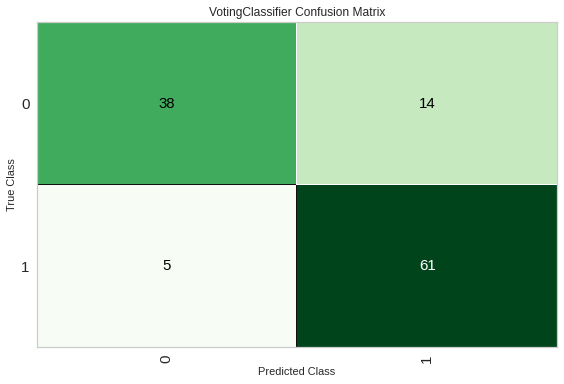

In [ ]:
plot_model(blended_model, plot = 'confusion_matrix')

In [ ]:
blended_model = finalize_model(blended_model)

In [ ]:
unseen_predictions = predict_model(blended_model, data = data_unseen)
unseen_predictions.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Label
0,63,F,ATA,140,195,0,Normal,179,N,0.0,Up,0,0
1,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1,0


In [ ]:
from pycaret.utils import check_metric

print("On Test Data")
print('Final Accuracy: {}'.format(check_metric(unseen_predictions.HeartDisease, unseen_predictions.Label, 'Accuracy')))
print('Final Precision: {}'.format(check_metric(unseen_predictions.HeartDisease, unseen_predictions.Label, 'Precision')))
print('Final Recall: {}'.format(check_metric(unseen_predictions.HeartDisease, unseen_predictions.Label, 'Recall')))
print('Final F1: {}'.format(check_metric(unseen_predictions.HeartDisease, unseen_predictions.Label, 'F1')))

On Test Data
Final Accuracy: 0.8406
Final Precision: 0.8947
Final Recall: 0.8293
Final F1: 0.8608


In [ ]:
save_model(blended_model, 'final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='HeartDisease',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_...
                                                                     weights='distance')),
                                               ('lr',
                                                LogisticRegression(C=1.459,
             